# Benchmark of loading dataset approaches in TensorFlow

This notebook benchmarks four different approaches to input a dataset to fit a model using TensorFlow. While it is possible to do it with a custom generator, the `tf.data` API offers possibilities which may be more confortable and even more efficient. Here the tested approaches:

* **a)** Using `.from_tensor_slices()`
* **b)** Using `.from_generator()`
* **c)** Using `.flow_from_directory()`
* **d)** Using `.tfrecords`

Let's start by importing the required packages and the configuration stored in `parameters.ini`.

In [1]:
import os
import subprocess
import matplotlib.pyplot as plt
import wandb
os.environ["WANDB_NOTEBOOK_NAME"] = os.path.join(os.getcwd(), "DatasetLoadingBenchmark.ipynb")
import utils
import configparser

config = configparser.ConfigParser()
config.read('parameters.ini')
N = int(config['DEFAULT']['n'])
HEIGHT = int(config['DEFAULT']['height'])
WIDTH = int(config['DEFAULT']['width'])
BATCH_SIZE = int(config['DEFAULT']['batch_size'])
BUFFER_SIZE = int(config['DEFAULT']['buffer_size'])
EPOCHS = int(config['DEFAULT']['epochs'])
STEPS = N // BATCH_SIZE

### Download toy data

To benchmark the dataset creation approaches, we need a task to solve, a toy dataset and a model to train. We will solve a segmentation task on the [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) ([Parkhi et al, 2012](https://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf)) with the UNet-like model provided in the [Image Segmentation TensorFlow tutorial](https://www.tensorflow.org/tutorials/images/segmentation). The next line of code downloads the dataset and structures it as follows in the determined `project` directory indicated with the variable `DATA_PATH`, defined in `parameters.ini`. It may take about 5 minutes.
```
{DATA_PATH}
|
└───images
│   |   image001.png
│   |   image002.png
│   |   ...
|
└───masks
    │   mask001.png
    │   mask002.png
    |   ...
```

In [2]:
DATA_PATH = os.path.join(os.getcwd(), "Data")
if not os.path.exists(DATA_PATH):
    os.mkdir(DATA_PATH)

utils.download_data(DATA_PATH)

Data is already in indicated path: ..\Data


### Create TensorFlow datasets with different approaches

##### **a)** Using `.from_tensor_slices()`

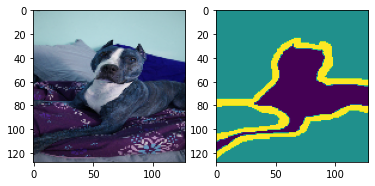

In [ ]:
from DatasetLoadingApproaches import using_from_tensor_slices
dataset_a = using_from_tensor_slices.get_dataset(DATA_PATH, BATCH_SIZE, BUFFER_SIZE)

for batch in dataset_a.take(1):
    sample_image = batch[0][0]
    sample_mask = batch[1][0]
    plt.subplot(1,2,1); plt.imshow(sample_image)
    plt.subplot(1,2,2); plt.imshow(sample_mask)

##### **b)** Using `.from_generator()`

100%|██████████| 10/10 [00:00<00:00, 20.62it/s]


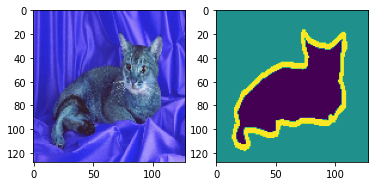

In [3]:
from DatasetLoadingApproaches import using_from_generator

# From paths
generator_b_from_paths = using_from_generator.get_generator_from_paths(DATA_PATH, BATCH_SIZE)
dataset_b_from_paths = using_from_generator.get_dataset_from_paths(DATA_PATH, BATCH_SIZE)

# From preloaded data (kind of a manual cache). It should be faster because data is already in the RAM during training and does not need to be loaded at every epoch
images_paths, masks_paths = using_from_generator.get_data_paths(DATA_PATH)
images = using_from_generator.load_samples(images_paths, "images", verbose=1)
masks = using_from_generator.load_samples(masks_paths, "masks", verbose=1)
generator_b_from_data = using_from_generator.get_generator_from_data(images, masks, BATCH_SIZE)
dataset_b_from_data = using_from_generator.get_dataset_from_data(images, masks, BATCH_SIZE)

for batch in dataset_b_from_data.take(5):
    sample_image = batch[0][0]
    sample_mask = batch[1][0]
    plt.subplot(1,2,1); plt.imshow(sample_image)
    plt.subplot(1,2,2); plt.imshow(sample_mask)

##### **c)** Using `.flow_from_directory()`

For this approach, we need to structure out data in subdirectories.

In [5]:
utils.structure_data_in_subdirectories(DATA_PATH)

Data is already in paths: ..\directory_images, ..\directory_masks


Create dataset

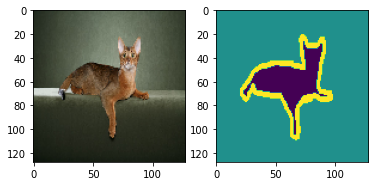

In [6]:
from DatasetLoadingApproaches import using_flow_from_directory

directory_images_path = os.path.join(DATA_PATH, "directory_images")
directory_masks_path = os.path.join(DATA_PATH, "directory_masks")
generator_c = using_flow_from_directory.get_generator(directory_images_path, directory_masks_path, BATCH_SIZE)
dataset_c = using_flow_from_directory.get_dataset(directory_images_path, directory_masks_path, BATCH_SIZE)

for batch in dataset_c.take(1):
    sample_image = batch[0][0]
    sample_mask = batch[1][0]
    plt.subplot(1,2,1)
    plt.imshow(sample_image)
    plt.subplot(1,2,2)
    plt.imshow(sample_mask)

##### **d)** Using `.tfrecords`

Create TFRECORDS files

In [7]:
from DatasetLoadingApproaches import tfrecords_creation

MAX_FILES = 15

tfrecords_path = os.path.join(DATA_PATH, "TFRecords")
if utils.get_size_in_megabytes(tfrecords_path) > 1800:
    print(f"TFRECORDS files are already in path: ..\{os.path.basename(tfrecords_path)}")
else:
    if not os.path.isdir(tfrecords_path):
        os.mkdir(tfrecords_path)
    tfrecords_creation.dynamic_write_images_to_tfr(DATA_PATH, MAX_FILES, tfrecords_path, filename="animals")

TFRECORDS files are already in path: ..\TFRecords


Create dataset

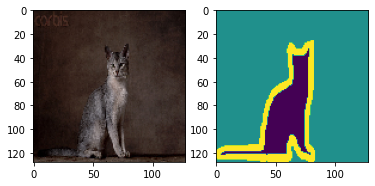

In [8]:
from DatasetLoadingApproaches import using_tfrecords

tfrecords_path = os.path.join(DATA_PATH, "TFRecords")
dataset_d = using_tfrecords.get_dataset(tfrecords_path, "animals*.tfrecords", BATCH_SIZE, BUFFER_SIZE)

for batch in dataset_c.take(1):
    sample_image = batch[0][0]
    sample_mask = batch[1][0]
    plt.subplot(1,2,1)
    plt.imshow(sample_image)
    plt.subplot(1,2,2)
    plt.imshow(sample_mask)

### Benchmark training performance

Define model

In [7]:
subprocess.check_call(["pip", "install", "git+https://github.com/tensorflow/examples.git"])

from segmentation_model import unet_model
model = unet_model(output_channels=3)

Segmentation Models: using `tf.keras` framework.


Train model with different dataset creation approaches

In [13]:
WANDB_ENTITY_NAME = "boadagu"
WANDB_PROJECT_NAME = "DatasetLoadingBenchmark"

datasets = [dataset_a, generator_b_from_paths, dataset_b_from_paths, generator_b_from_data, dataset_b_from_data, dataset_c, dataset_d]
run_names = ["Using .from_tensor_slices()", "Using simple generator", "Using .from_generator()", "Using simple generator with preloaded data", "Using .from_generator() with preloaded data", "Using .flow_from_directory()", "Using .tfrecords"]
for i,(run_name,dataset) in enumerate(zip(run_names, datasets)):
    if i>1: # To skip the first to approaches which were already run
        wandb.init(project=WANDB_PROJECT_NAME, entity=WANDB_ENTITY_NAME, name=run_name + f" [{EPOCHS} epochs]")
        model.fit(dataset, epochs=EPOCHS, steps_per_epoch=STEPS, callbacks=[utils.MonitorCallback()])
        wandb.finish()

wandb: Currently logged in as: boadagu (use `wandb login --relogin` to force relogin)
C:\Users\boadagu\.conda\envs\replica-env\lib\site-packages\IPython\html.py:12: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  warn("The `IPython.html` package has been deprecated since IPython 4.0. "


Epoch 1/100
923/923 [==============================] - 259s 274ms/step - loss: 0.4051 - accuracy: 0.8412
Epoch 2/100
923/923 [==============================] - 206s 223ms/step - loss: 0.2886 - accuracy: 0.8899
Epoch 3/100
923/923 [==============================] - 185s 200ms/step - loss: 0.2720 - accuracy: 0.8960
Epoch 4/100
923/923 [==============================] - 184s 200ms/step - loss: 0.2598 - accuracy: 0.9004
Epoch 5/100
923/923 [==============================] - 194s 210ms/step - loss: 0.2482 - accuracy: 0.9042
Epoch 6/100
923/923 [==============================] - 219s 237ms/step - loss: 0.2415 - accuracy: 0.9066
Epoch 7/100
923/923 [==============================] - 185s 201ms/step - loss: 0.2328 - accuracy: 0.9095
Epoch 8/100
923/923 [==============================] - 184s 200ms/step - loss: 0.2238 - accuracy: 0.9129
Epoch 9/100
923/923 [==============================] - 186s 202ms/step - loss: 0.2141 - accuracy: 0.9165
Epoch 10/100
923/923 [==============================] -

RAM (%),▅▄▄▁▆▃▄▆▁▃▃▁▅▂▆▂▇▃▃▅▄▅▇██▃▇▆▇▄█▇▆▁▅▆▃▆█▆
RAM (MB),▅▄▄▁▆▃▄▆▁▃▃▁▅▂▆▂▇▃▃▅▄▅▇██▃▇▆▇▄█▇▆▁▅▆▃▆█▆
VRAM (MB) from smi,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
VRAM (MB) from tf,▁▃▂▃▅▂█▃▃▄▅▂▃▄▃▆█▃▅▆▅█▆▂▂▂▄▃▃▂▆▅▄▃▆▄▅▆▅▃
RAM (%),64.1
RAM (MB),20834.35938
VRAM (MB) from smi,5726.27354
VRAM (MB) from tf,67.39771


Epoch 1/100
923/923 [==============================] - 187s 201ms/step - loss: 0.0516 - accuracy: 0.9804
Epoch 2/100
923/923 [==============================] - 186s 202ms/step - loss: 0.0539 - accuracy: 0.9798
Epoch 3/100
923/923 [==============================] - 189s 205ms/step - loss: 0.0452 - accuracy: 0.9828
Epoch 4/100
923/923 [==============================] - 209s 226ms/step - loss: 0.0453 - accuracy: 0.9828
Epoch 5/100
923/923 [==============================] - 215s 233ms/step - loss: 0.0462 - accuracy: 0.9825
Epoch 6/100
923/923 [==============================] - 185s 201ms/step - loss: 0.0460 - accuracy: 0.9825
Epoch 7/100
923/923 [==============================] - 187s 202ms/step - loss: 0.0459 - accuracy: 0.9826
Epoch 8/100
923/923 [==============================] - 187s 203ms/step - loss: 0.0456 - accuracy: 0.9827
Epoch 9/100
923/923 [==============================] - 186s 202ms/step - loss: 0.0454 - accuracy: 0.9828
Epoch 10/100
923/923 [==============================] -

RAM (%),▄▂▅▁▂▃▂▃▃▃▁▂▂▆█▄▄▄▅▆▃▂▆▂▃▄▃▄▃▄▂▁▂▂▅▁▃▁▇▅
RAM (MB),▄▂▅▁▂▃▂▃▃▃▁▂▂▆█▄▄▄▅▆▃▂▆▂▃▄▃▄▃▄▂▁▂▂▅▁▃▁▇▅
VRAM (MB) from smi,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
VRAM (MB) from tf,▁▂▂▄▆▄▃▃▅▂▃▃▇▂▂▄▄▃▄▂▃▃▂▃▂▃▅▄▄▃▅▄▄▅▅█▆▄▇▆
RAM (%),64.9
RAM (MB),21100.19141
VRAM (MB) from smi,5726.27354
VRAM (MB) from tf,67.40063


Run pip install nbformat to save notebook history
Traceback (most recent call last):
  File "C:\Users\boadagu\.conda\envs\replica-env\lib\site-packages\wandb\sdk\wandb_init.py", line 931, in init
    run = wi.init()
  File "C:\Users\boadagu\.conda\envs\replica-env\lib\site-packages\wandb\sdk\wandb_init.py", line 597, in init
    self.teardown()
  File "C:\Users\boadagu\.conda\envs\replica-env\lib\site-packages\wandb\sdk\wandb_init.py", line 221, in teardown
    hook.call()
  File "C:\Users\boadagu\.conda\envs\replica-env\lib\site-packages\wandb\sdk\wandb_init.py", line 301, in _jupyter_teardown
    res = self.run.log_code(root=None)
AttributeError: 'NoneType' object has no attribute 'log_code'
error
Traceback (most recent call last):
  File "C:\Users\boadagu\.conda\envs\replica-env\lib\site-packages\wandb\sdk\wandb_init.py", line 931, in init
    run = wi.init()
  File "C:\Users\boadagu\.conda\envs\replica-env\lib\site-packages\wandb\sdk\wandb_init.py", line 597, in init
    self.teard

Problem at: C:\Users\boadagu\AppData\Local\Temp/ipykernel_29608/2104802826.py 7 <module>


wandb: ERROR Abnormal program exit


### Results
<img src="TrainingTimes.png" style="width: 1000px;"/>
<!-- Times in seconds are: [310, 361, 407, 383, 362] -->

Using `.tfrecords` is the fasted (5 min 10 s) approach compared to the other ones (Average: 6 min 20 s). This is because TFRECORDS files save the data in a binarized format and in a sequentially structure, so that samples can be accessed faster. 